# Data and libraries loading
First of all we exported the data from the excel file and saved it as a csv file.
Then we formatted the data to be easily compatible with pandas.
We did so by using the following commands in the vim editor:
```vim
:%s/\.//g
:%s/,/./g
:wq
```

In [2]:
# import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller as adf, add_constant
from statsmodels.stats.stattools import durbin_watson as durbin_watson, \
    jarque_bera
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.diagnostic import het_breuschpagan as breusch_pagan
from arch import arch_model

In [3]:

# load the data from the csv file, setting the date column as the index
df = pd.read_csv('InvestmentReplica.csv', delimiter=';')
# convert the date column to datetime format and set it as the index
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.set_index('Date', inplace=True)
# extract the indexes
indexes = ['HFRXGL', 'LEGATRUU', 'MXWD', 'MXWO']
indexes = df[indexes]

# extract the futures
futures = ['CO1','DU1','ES1','GC1','LLL1','NQ1','RX1','TP1','TU2','TY1','VG1']
futures = df[futures]

# Data Exploration
## Target data exploration
Let us plot the graphs of the indexes of the data to see how they are distributed.

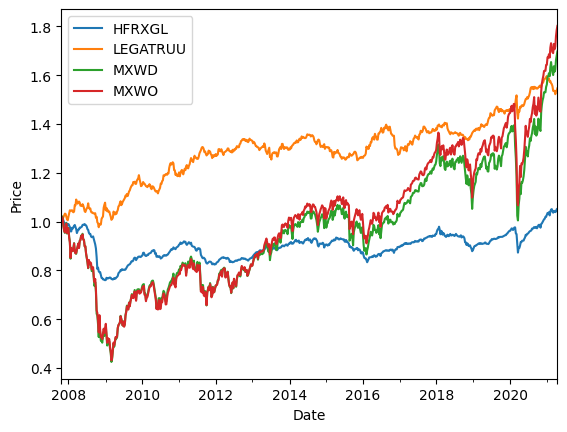

In [4]:
# graph the indexes normalized to the first value
indexes_plot = indexes.div(indexes.iloc[0]).plot()
indexes_plot.set_xlabel('Date')
indexes_plot.set_ylabel('Price')
indexes_plot.legend(loc='upper left')
plt.show()

# Target portfolio selection
We create the target portfolio as the minimum variance portfolio of the four
indexes with the a fixed return of 10%.
We do so by using the following weights:

$$ w_i = \frac{{\Sigma^{-1} \left( \mu - r \cdot \mathbf{1} \right)}}
{\mathbf{1}^T \cdot \Sigma^{-1} \left( \mu - r \cdot \mathbf{1} \right)}
$$

where $\Sigma$ is the covariance matrix and $\mu$ is the vector of expected returns and r is the fixed return we want to achieve.

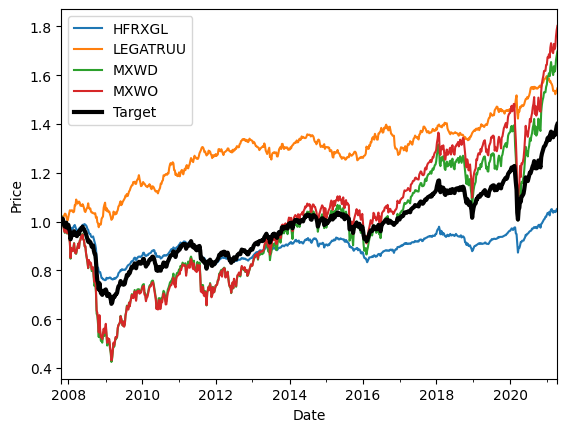


Minimum Variance Portfolio:
Weights: [ 0.62083829  0.43728726 -0.5711139   0.51298836]
Expected Return: 0.0005389851958403989
Standard Deviation: 0.000120860194646666



In [5]:
# Define the expected returns, covariance matrix, and fixed return
returns = indexes.pct_change().dropna()
expected_returns = returns.mean()
covariance_matrix = returns.cov()
covariance_inverse = np.linalg.inv(covariance_matrix)
ones = np.ones(len(expected_returns))
fixed_return = 0.3
# Calculate the numerator and denominator of the weight formula
numerator = covariance_inverse @ (expected_returns - ones * fixed_return)
denominator = ones @ covariance_inverse @ (expected_returns - ones * fixed_return)
# Calculate the weights of the minimum variance portfolio for the fixed return
weights = numerator / denominator
target = indexes.dot(weights)
target.name = 'Target'

# graph the indexes normalized to the first value and the minimum variance portfolio
indexes_plot = indexes.div(indexes.iloc[0]).plot()
indexes_plot.set_xlabel('Date')
indexes_plot.set_ylabel('Price')
target_plot = target.div(target.iloc[0]).plot(lw=3, color='black', label='Target', ax=indexes_plot)
indexes_plot.legend(loc='upper left')
plt.show()

# show the weights of the minimum variance portfolio, the expected return and
# the standard deviation
print(f"""
Minimum Variance Portfolio:
Weights: {weights}
Expected Return: {target.pct_change().mean()}
Standard Deviation: {target.pct_change().var()}
""")

### Stationarity test
#### Original data

In [6]:
# test the stationarity of the minimum variance portfolio
adf_tes = adf(target)
print(f""" --- Augmented Dickey-Fuller test ---

- adf_tes Statistic: {adf_tes[0]:.4f}
- p-value: {adf_tes[1]:.4f}
- Critical values: {" ".join([f"{t}: {v:.1f}" for t,v in adf_tes[4].items()]) }
- {"We accept H0, the series is stationary" if adf_tes[1] < 0.05
    else "We reject H0, the series is not stationary"}
    (alpha = 0.05)
""")

 --- Augmented Dickey-Fuller test ---

- adf_tes Statistic: 0.6445
- p-value: 0.9887
- Critical values: 1%: -3.4 5%: -2.9 10%: -2.6
- We reject H0, the series is not stationary
    (alpha = 0.05)



#### Log Returns

In [7]:
# we test the stationarity of the minimum variance portfolio using the
# log returns
target_log_returns = np.log(target).diff().dropna() # = log(pt/pt-1)
adf_test = adf(target_log_returns)
print(f""" --- Augmented Dickey-Fuller test ---
- adf_test Statistic: {adf_test[0]:.4f}
- p-value: {adf_test[1]:.4f}
- Critical values: {" ".join([f"{t}: {v:.1f}" for t,v in adf_test[4].items()]) }
- {"We accept H0, the series is stationary" if adf_test[1] < 0.05
    else "We reject H0, the series is not stationary"}
    (alpha = 0.05)
""")

 --- Augmented Dickey-Fuller test ---
- adf_test Statistic: -22.5506
- p-value: 0.0000
- Critical values: 1%: -3.4 5%: -2.9 10%: -2.6
- We accept H0, the series is stationary
    (alpha = 0.05)



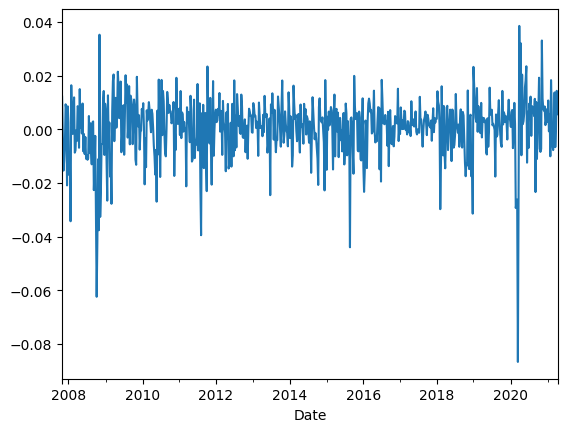

In [8]:
# graph the log returns of the target
target_log_returns.plot()
plt.show()

## Regressors exploration

### Graph

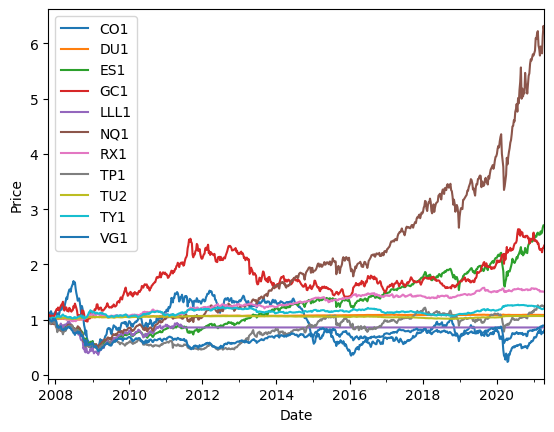

In [9]:
# we plot the futures returns normalized to the first value
futures_plot = futures.div(futures.iloc[0]).plot()
futures_plot.set_xlabel('Date')
futures_plot.set_ylabel('Price')
futures_plot.legend(loc='upper left')
plt.show()

### Covariance matrix

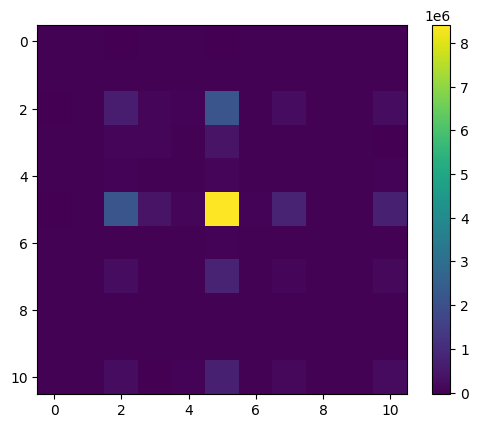

In [10]:
# plot the covariance matrix of the futures
covariance_matrix_plot = plt.imshow(futures.cov())
plt.colorbar(covariance_matrix_plot)
plt.show()

Here there is a lot of space for feature reduction and the use of collinearity,
we could introduce some ratios or eliminate some variables.

### Stationarity test
#### Original data

In [11]:
# we test the stationarity of the futures using the Augmented Dickey-Fuller test
alpha = 0.05
for future in futures:
    adf_test = adf(futures[future])
    print(f"{future} - p-value: {adf_test[1]:.4f} - " \
        f"{'Stationary' if adf_test[1] < alpha else 'Not Stationary'}")

CO1 - p-value: 0.1221 - Not Stationary
DU1 - p-value: 0.1792 - Not Stationary
ES1 - p-value: 0.9987 - Not Stationary
GC1 - p-value: 0.4836 - Not Stationary
LLL1 - p-value: 0.0110 - Stationary
NQ1 - p-value: 1.0000 - Not Stationary
RX1 - p-value: 0.6454 - Not Stationary
TP1 - p-value: 0.7564 - Not Stationary
TU2 - p-value: 0.3154 - Not Stationary
TY1 - p-value: 0.0818 - Not Stationary
VG1 - p-value: 0.0395 - Stationary


As we can see most of the regressors are not stationary, so we will try to see
if the first differences are stationary instead.

In [12]:
# we try to stationarize the futures using the log returns just like we did
# with the indexes
futures_log_returns = np.log(futures).diff().dropna()
for future in futures_log_returns:
    adf_test = adf(futures_log_returns[future])
    print(f"{future} - p-value: {adf_test[1]:.4f} - " \
        f"{'Stationary' if adf_test[1] < alpha else 'Not Stationary'}")

CO1 - p-value: 0.0000 - Stationary
DU1 - p-value: 0.0000 - Stationary
ES1 - p-value: 0.0000 - Stationary
GC1 - p-value: 0.0000 - Stationary
LLL1 - p-value: 0.0004 - Stationary
NQ1 - p-value: 0.0000 - Stationary
RX1 - p-value: 0.0000 - Stationary
TP1 - p-value: 0.0000 - Stationary
TU2 - p-value: 0.0000 - Stationary
TY1 - p-value: 0.0000 - Stationary
VG1 - p-value: 0.0000 - Stationary


Since all the series are now stationary we can proceed with the analysis and accept the null hypothesis of no cointegration.

# Model selection
## OLS vanilla regression

In [13]:
# build a vanilla linear regression model to predict the minimum variance
# portfolio using the futures (using the returns)
futures_log_returns= add_constant(futures_log_returns)
model = OLS(target_log_returns, futures_log_returns)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Target   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     390.1
Date:                Wed, 24 May 2023   Prob (F-statistic):          5.85e-288
Time:                        23:43:35   Log-Likelihood:                 2866.7
No. Observations:                 704   AIC:                            -5709.
Df Residuals:                     692   BIC:                            -5655.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.346e-05      0.000     -0.273      0.7

**TO REVISE**  
Here we could directly verify the assumptions of the OLS regression, since
the OLS model from the statsmodels library does provide the various test
statistics in the summary. But I have no idea how to interpret them so I 
will test the assumptions manually.

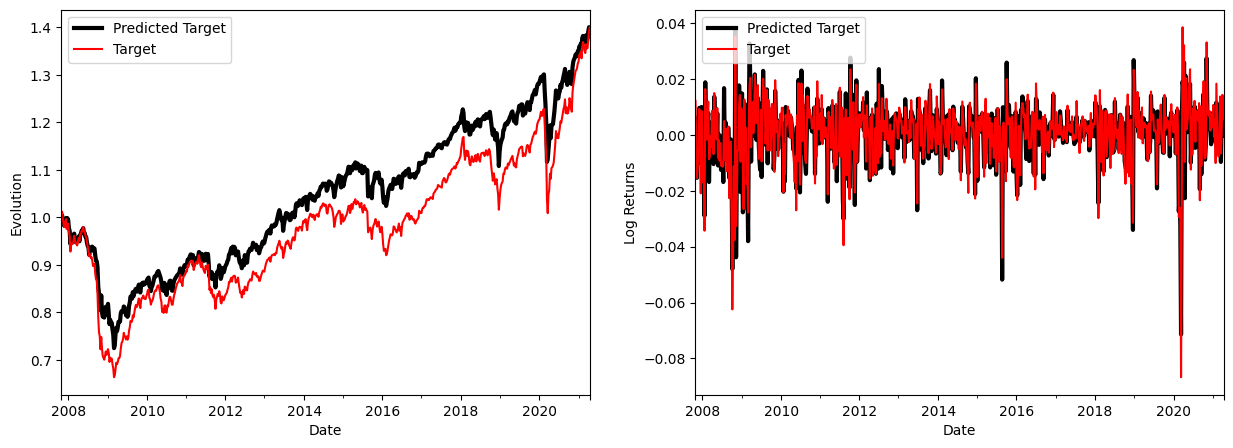

In [14]:
# reconstruct the predicted minimum variance portfolio from the predicted
# returns
predicted_target_log_returns = results.predict(futures_log_returns)
predicted_target = np.exp(predicted_target_log_returns).cumprod()
predicted_target = pd.concat([
    pd.Series(1, index=[target.index[0]]), predicted_target
])

# create two panels, one with the portfolio and one with the returns
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(15,5))
# graph the predicted minimum variance portfolio along with the actual
# minimum variance portfolio
predicted_target_plot = predicted_target.plot( lw=3, color='black',
    label='Predicted Target', ax=ax1)
target_plot = target.div(target.iloc[0]).plot(color='red', label='Target', ax=predicted_target_plot)
predicted_target_plot.set_ylabel('Evolution')
predicted_target_plot.legend(loc='upper left')

# graph the predicted minimum variance portfolio log returns along with the actual
# minimum variance portfolio log returns
predicted_target_log_returns_plot = predicted_target_log_returns.plot(
    lw=3, color='black', label='Predicted Target', ax=ax2)
target_log_returns_plot = target_log_returns.plot(
    color='red', label='Target', ax=predicted_target_log_returns_plot)
predicted_target_log_returns_plot.set_ylabel('Log Returns')
predicted_target_log_returns_plot.legend(loc='upper left')
plt.show()

#### Verifying the assumptions of the OLS model
##### Residuals mean is zero and finite variance

In [15]:
# test the assumptions of the linear regression model
residuals = results.resid
residuals_mean = residuals.mean()
print(f"Mean of the residuals: {residuals_mean}")
residuals_variance = residuals.var()
print(f"Variance of the residuals: {residuals_variance}")

Mean of the residuals: -1.7754303393619446e-16
Variance of the residuals: 1.7029067761054996e-05


##### Residuals are Homoscedastic
We use the [Breusch-Pagan test](https://en.wikipedia.org/wiki/Breusch%E2%80%93Pagan_test) to verify the homoskedasticity of the residuals.

In [16]:
# add a constant to the futures log returns
# test the homoskedasticity of the residuals using the Breusch-Pagan test
bp_test = breusch_pagan(residuals, futures_log_returns)
print(f""" --- Breusch-Pagan test ---
- LM Statistic: {bp_test[0]:.4f}
- p-value: {bp_test[1]:.4f}
- F-Statistic: {bp_test[2]:.4f}
- F-Statistic p-value: {bp_test[3]:.4f}
- {"We accept H0, the residuals are homoskedastic" if bp_test[1] > alpha
    else "We reject H0, the residuals are heteroskedastic"}
    (alpha = 0.05)
""")

 --- Breusch-Pagan test ---
- LM Statistic: 66.3468
- p-value: 0.0000
- F-Statistic: 6.5456
- F-Statistic p-value: 0.0000
- We reject H0, the residuals are heteroskedastic
    (alpha = 0.05)



##### Durbins-Watson test for autocorrelation
We use the [Durbin-Watson test](https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic)
to verify the autocorrelation (at lag=1) of the residuals.

In [17]:
# test the autocorrelation of the residuals using the Durbin-Watson test
dw_test = durbin_watson(residuals)
print(f""" --- Durbin-Watson test ---
- DW Statistic: {dw_test:.4f}
- {"We accept H0, the residuals are not autocorrelated" if dw_test > 1.5 and dw_test < 2.5
    else "We reject H0, the residuals are autocorrelated"}
""")

 --- Durbin-Watson test ---
- DW Statistic: 2.0900
- We accept H0, the residuals are not autocorrelated



As we can see there doesn't seem to be any autocorrelation in the residuals
since the Durbin-Watson test statistic is very close to 2.

##### Jarque-Bera test for normality

In [18]:
# test the normality of the residuals using the Jarque-Bera test
jb_test = jarque_bera(residuals)
print(f""" --- Jarque-Bera test ---
- JB Statistic: {jb_test[0]:.4f}
- p-value: {jb_test[1]:.4f}
- Skewness: {jb_test[2]:.4f}
- Kurtosis: {jb_test[3]:.4f}
- {"We accept H0, the residuals are normally distributed" if jb_test[1] > alpha
    else "We reject H0, the residuals are not normally distributed"}
    (alpha = 0.05)
""")

 --- Jarque-Bera test ---
- JB Statistic: 2250.0790
- p-value: 0.0000
- Skewness: -1.1468
- Kurtosis: 11.4526
- We reject H0, the residuals are not normally distributed
    (alpha = 0.05)



## ARCH and GARCH models
ARCH and GARCH model are models used when we have evidence for
heteroskedasticity. In particular ARCH stands for **A**uto**R**egressive
**C**onditional **H**eteroskedasticity while GARCH stands for
**G**eneralized **ARCH**.  
In practice we estimate target portfolio differences with an OLS method using
the futures differences as regressors:

$$ \Delta y_t = \alpha + \beta \Delta x_t + \epsilon_t $$

where $y_t$ is the target portfolio and $x_t$ is the vector of the regressors.
Then we suppose that the residuals $\epsilon_t$ are of the form:

$$ \epsilon_t \sim \mathcal{N} \left( 0, \sigma_t^2 \right) $$

where $\sigma_t^2$ is the variance of the residuals and that the variance can be
modeled through an AR (ARHC) or ARMA (GARCH) process.  
In particular a GARCH(p,q) process is defined as:

$$ \sigma_t^2 = \omega + \sum_{i=1}^p \alpha_i \epsilon_{t-i}^2 +
    \sum_{j=1}^q \beta_j \sigma_{t-j}^2 $$

where $\omega$ is the constant term, $\alpha_i$ and $\beta_j$ are
the coefficients.

### Lag selection
We perform the lag selection studying the ACF and PACF of the volatility.

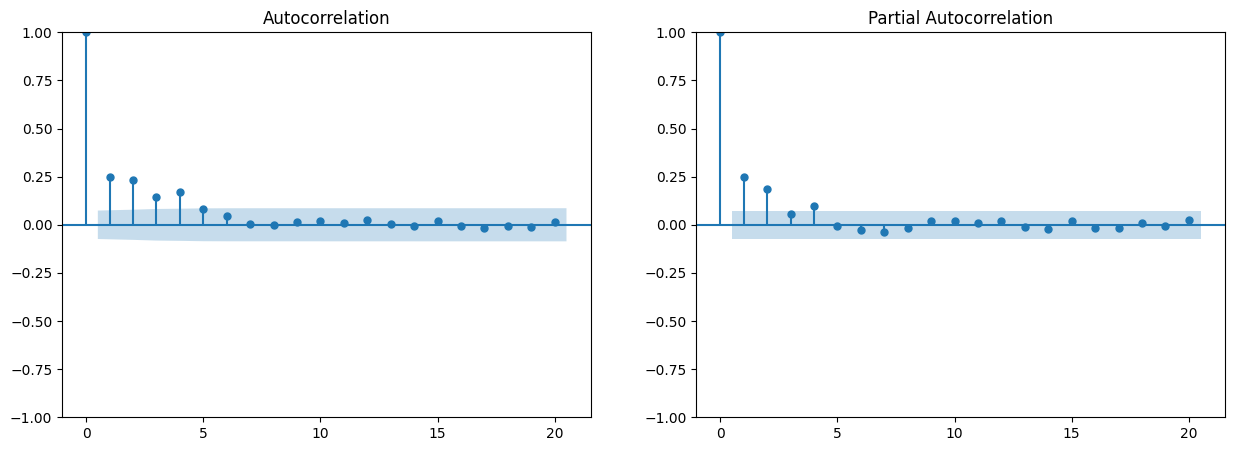

In [19]:
# graph the squared residuals as a proxy for the volatility
# two panels are created, one with the autocorrelation function and one with
# the partial autocorrelation function
squared_log_returns = target_log_returns ** 2

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(15,5))
plot_acf(squared_log_returns, ax=ax1, lags=20)
plot_pacf(squared_log_returns, ax=ax2, lags=20)
plt.show()

As we can observe the ACF tells us that the best value for p is 4 while the
PACF tells us that the best value for q is 2.
Nonetheless, since the literature suggests that the best results are usually
obtained by a simple GARCH(1,1) model we will also evaluate the results of
such model.

### ARCH models
#### ARCH(1) with constant mean

In [20]:
# create an ARCH(1) model for the residuals with a constant mean
arch_const_model = arch_model(100 * target_log_returns, mean='constant', vol='ARCH', p=1)
arch_const_results = arch_const_model.fit(disp=False) # set to True for details
print(arch_const_results.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                 Target   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1002.98
Distribution:                  Normal   AIC:                           2011.95
Method:            Maximum Likelihood   BIC:                           2025.62
                                        No. Observations:                  704
Date:                Wed, May 24 2023   Df Residuals:                      703
Time:                        23:44:51   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1382  3.677e-02      3.760  1.702e-04 [6.617e-0

In [21]:
# build an ARCH(1) model for the residuals with the OLS from above for the mean
arch_OLS_model = arch_model(100 * residuals, mean='Constant', vol='ARCH', p=4)
arch_OLS_results = arch_OLS_model.fit(disp='off')
print(arch_OLS_results.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -279.241
Distribution:                  Normal   AIC:                           570.481
Method:            Maximum Likelihood   BIC:                           597.822
                                        No. Observations:                  704
Date:                Wed, May 24 2023   Df Residuals:                      703
Time:                        23:45:25   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0105  1.153e-02      0.907      0.364 

As we can see the AIC and BIC have gone down substantially and the p-values seem
to be very good. Hence the ARCH(4) model seems to outperform the ARCH(1) model.

In [ ]:
# get the arch predicted volatility
arch_volatility = arch_OLS_results.conditional_volatility / 100
# get the 95% confidence interval for the log returns
log_return_high = target_log_returns + 1.96 * arch_volatility
log_return_low = target_log_returns - 1.96 * arch_volatility

# reconstruct the predicted minimum variance portfolio from the predicted
# log returns
predicted_target = np.exp(predicted_target_log_returns).cumprod()
# create the confidence interval as the 1-step ahead forecast
high = predicted_target * np.exp(log_return_high)
low = predicted_target * np.exp(log_return_low)

# create two panels, one with the portfolio and one with the returns
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(15,5))
# graph the predicted minimum variance portfolio along with the actual
# minimum variance portfolio
predicted_target_plot = predicted_target.plot( lw=3, color='black',
    label='Predicted Target', ax=ax1)
target_plot = target.div(target.iloc[0]).plot(color='red', label='Target', ax=predicted_target_plot)
predicted_target_plot.fill_between(
    high.index, high, low, color='black', alpha=0.1)
predicted_target_plot.set_ylabel('Evolution')
predicted_target_plot.legend(loc='upper left')

# graph the predicted minimum variance portfolio log returns along with the actual
# minimum variance portfolio log returns and the 95% confidence interval as a
# shaded area
predicted_target_log_returns_plot = predicted_target_log_returns.plot(
    lw=3, color='black', label='Predicted Target', ax=ax2)
target_log_returns_plot = target_log_returns.plot(
    color='red', label='Target', ax=predicted_target_log_returns_plot)
predicted_target_log_returns_plot.fill_between(
    log_return_high.index, log_return_high, log_return_low,
    color='black', alpha=0.1)
predicted_target_log_returns_plot.set_ylabel('Log Returns')
predicted_target_log_returns_plot.legend(loc='upper left')
plt.show()

### GARCH model

In [ ]:
# build the garch model for the minimum variance portfolio using a
# Least Squares Regression for the mean and a GARCH(1,1) for the variance
garch_OLS_model = arch_model(100 * residuals,
    mean='Zero', vol='GARCH', p=1, q=1)
garch_OLS_results = garch_OLS_model.fit(disp=False) # set to True for details
print(garch_OLS_results.summary())

p-values have gone up but the AIC has decreased, so we can say that the GARCH
model is better than the plain ARCH model.

In [ ]:
# plot the garch model residuals and volatility
garch_OLS_results.plot()
plt.show()